# MDI+: Example Usages

In [1]:
%reload_ext autoreload
%autoreload 2
import sys
sys.path.append("../")
sys.path.append("../../")

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor, RandomForestClassifier
from sklearn.metrics import r2_score, mean_absolute_error, accuracy_score, roc_auc_score, mean_squared_error

from imodels.importance import RandomForestPlusRegressor, RandomForestPlusClassifier, \
    RidgeRegressorPPM, LassoRegressorPPM, IdentityTransformer
from imodels.importance.rf_plus import _fast_r2_score

In [2]:
# helper variables
rf_regressor = RandomForestRegressor(n_estimators=100, min_samples_leaf=5, max_features=0.33, random_state=331)
rf_classifier = RandomForestClassifier(n_estimators=100, min_samples_leaf=1, max_features="sqrt", random_state=331)

## 1. Regression Example

In [3]:
# generate data from linear model: y = x1 + x2 + N(0, 1)
n = 200
p = 10
s = 2
X = np.random.normal(size=(n, p))
beta = np.concatenate((np.ones(s), np.zeros(p-s)))
y = np.matmul(X, beta) + np.random.normal(size=n)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=12345)

### 1.1 Local MDI+ (Feature Contribution) w/ Regression

In [4]:
# fit RF+
rf_plus_model = RandomForestPlusRegressor(rf_model=rf_regressor, include_raw=False)
rf_plus_model.fit(X_train, y_train)

In [5]:
# make predictions with RF+
preds = rf_plus_model.predict(X_test)
r2_score(y_test, preds)

0.45214067187768947

#### Leave-One-Out Coefficients: $LFI(i,k)=\sum_{j=1}^p|\hat{\beta}^{(k)}_{-i,j}*\Psi^{(k)}_{i,j}|$

In [6]:
# get MDI+ scores (higher r^2 value = greater importance)
mdi_plus_scores = rf_plus_model.get_mdi_plus_scores(X_train, y_train, lfi=True,
                                                    lfi_abs = "inside")

Using LOO Coefficients for Training Data!
BLOCK K SHAPE (134, 3)
BLOCK K SHAPE (134, 3)
BLOCK K SHAPE (134, 0)
BLOCK K SHAPE (134, 1)
BLOCK K SHAPE (134, 0)
BLOCK K SHAPE (134, 2)
BLOCK K SHAPE (134, 1)
BLOCK K SHAPE (134, 0)
BLOCK K SHAPE (134, 1)
BLOCK K SHAPE (134, 3)
Using LOO Coefficients for Training Data!
BLOCK K SHAPE (134, 1)
BLOCK K SHAPE (134, 1)
BLOCK K SHAPE (134, 3)
BLOCK K SHAPE (134, 0)
BLOCK K SHAPE (134, 2)
BLOCK K SHAPE (134, 2)
BLOCK K SHAPE (134, 1)
BLOCK K SHAPE (134, 1)
BLOCK K SHAPE (134, 2)
BLOCK K SHAPE (134, 0)
Using LOO Coefficients for Training Data!
BLOCK K SHAPE (134, 2)
BLOCK K SHAPE (134, 1)
BLOCK K SHAPE (134, 2)
BLOCK K SHAPE (134, 0)
BLOCK K SHAPE (134, 1)
BLOCK K SHAPE (134, 2)
BLOCK K SHAPE (134, 1)
BLOCK K SHAPE (134, 0)
BLOCK K SHAPE (134, 1)
BLOCK K SHAPE (134, 3)
Using LOO Coefficients for Training Data!
BLOCK K SHAPE (134, 3)
BLOCK K SHAPE (134, 3)
BLOCK K SHAPE (134, 1)
BLOCK K SHAPE (134, 0)
BLOCK K SHAPE (134, 0)
BLOCK K SHAPE (134, 1)
BLOC

Local MDI+ w/ Leave-One-Out Coefficients and Inner Absolute Value
------------------------------------
            0         1         2         3         4         5         6  \
0    0.669133  0.777696  0.039445  0.062809  0.058721  0.063172  0.074013   
1    0.858029  0.699634  0.029288  0.037480  0.071149  0.078592  0.065829   
2    0.954317  0.661745  0.024357  0.046488  0.047876  0.066085  0.068481   
3    0.669230  0.893709  0.027532  0.069654  0.048910  0.042780  0.074295   
4    0.626225  0.881417  0.029357  0.082438  0.045663  0.065179  0.075162   
..        ...       ...       ...       ...       ...       ...       ...   
129  0.598543  0.720115  0.036418  0.073922  0.037260  0.072919  0.111588   
130  0.766971  0.777962  0.034914  0.064810  0.034436  0.078817  0.072758   
131  0.635553  0.730505  0.045573  0.068693  0.054489  0.070601  0.080038   
132  0.795860  0.656903  0.038157  0.048497  0.048857  0.072276  0.080002   
133  0.779389  0.648543  0.037368  0.051911  0.053

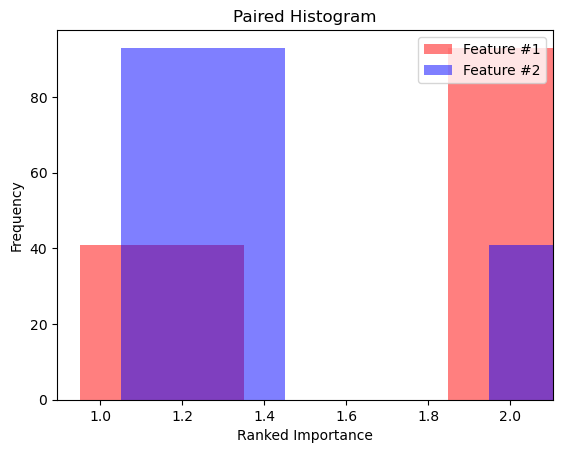

In [7]:
print("Local MDI+ w/ Leave-One-Out Coefficients and Inner Absolute Value")
print("------------------------------------")
lfi_loo_inner = mdi_plus_scores["lfi"]
print(lfi_loo_inner)
print("------------------------------------")
print("Recall that the first two columns are the only ones with signal.")
print("Histogram of Rank of First Column (Red) and Second Column (Blue)")
lfi_rank = lfi_loo_inner.rank(axis=1, method="dense", ascending=False)
fig, ax = plt.subplots()
ax.hist(lfi_rank.iloc[:, 0], alpha = 0.5, label='Feature #1', align = "left",
        width = 0.4, color = "red")
ax.hist(lfi_rank.iloc[:, 1], alpha = 0.5, label='Feature #2', align = "right",
        width = 0.4, color = "blue")
ax.set_xlabel('Ranked Importance')
ax.set_ylabel('Frequency')
ax.set_title('Paired Histogram')
ax.legend()
plt.show()

#### Leave-One-Out Coefficients: $LFI(i,k)=|\sum_{j=1}^p\hat{\beta}^{(k)}_{-i,j}*\Psi^{(k)}_{i,j}|$

In [8]:
# get MDI+ scores (higher r^2 value = greater importance)
mdi_plus_scores = rf_plus_model.get_mdi_plus_scores(X_train, y_train, lfi=True,
                                                    lfi_abs = "outside")

Using LOO Coefficients for Training Data!
BLOCK K SHAPE (134, 3)
BLOCK K SHAPE (134, 3)
BLOCK K SHAPE (134, 0)
BLOCK K SHAPE (134, 1)
BLOCK K SHAPE (134, 0)
BLOCK K SHAPE (134, 2)
BLOCK K SHAPE (134, 1)
BLOCK K SHAPE (134, 0)
BLOCK K SHAPE (134, 1)
BLOCK K SHAPE (134, 3)
Using LOO Coefficients for Training Data!
BLOCK K SHAPE (134, 1)
BLOCK K SHAPE (134, 1)
BLOCK K SHAPE (134, 3)
BLOCK K SHAPE (134, 0)
BLOCK K SHAPE (134, 2)
BLOCK K SHAPE (134, 2)
BLOCK K SHAPE (134, 1)
BLOCK K SHAPE (134, 1)
BLOCK K SHAPE (134, 2)
BLOCK K SHAPE (134, 0)
Using LOO Coefficients for Training Data!
BLOCK K SHAPE (134, 2)
BLOCK K SHAPE (134, 1)
BLOCK K SHAPE (134, 2)
BLOCK K SHAPE (134, 0)
BLOCK K SHAPE (134, 1)
BLOCK K SHAPE (134, 2)
BLOCK K SHAPE (134, 1)
BLOCK K SHAPE (134, 0)
BLOCK K SHAPE (134, 1)
BLOCK K SHAPE (134, 3)
Using LOO Coefficients for Training Data!
BLOCK K SHAPE (134, 3)
BLOCK K SHAPE (134, 3)
BLOCK K SHAPE (134, 1)
BLOCK K SHAPE (134, 0)
BLOCK K SHAPE (134, 0)
BLOCK K SHAPE (134, 1)
BLOC

Local MDI+ w/ Leave-One-Out Coefficients and Outer Absolute Value
------------------------------------
            0         1         2         3         4         5         6  \
0    0.490219  0.706766  0.039116  0.062190  0.057328  0.059699  0.072034   
1    0.824998  0.588418  0.028956  0.034361  0.067249  0.077231  0.061236   
2    0.920962  0.603645  0.022329  0.042830  0.046554  0.063875  0.065650   
3    0.469675  0.848808  0.026910  0.064592  0.038685  0.040954  0.066297   
4    0.481781  0.841002  0.028481  0.079209  0.042935  0.061837  0.067113   
..        ...       ...       ...       ...       ...       ...       ...   
129  0.428560  0.535581  0.035863  0.070922  0.035309  0.069770  0.106652   
130  0.545962  0.711408  0.034342  0.061451  0.031958  0.076242  0.068857   
131  0.449462  0.584565  0.045335  0.062231  0.052735  0.053904  0.073850   
132  0.700362  0.471545  0.037811  0.044047  0.046474  0.070963  0.070715   
133  0.655068  0.475510  0.036612  0.050731  0.051

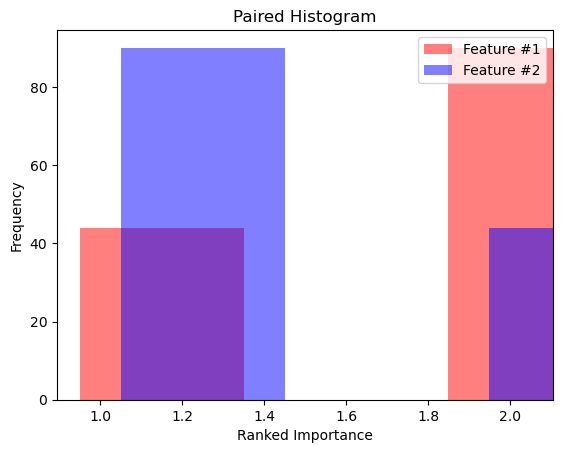

In [9]:
print("Local MDI+ w/ Leave-One-Out Coefficients and Outer Absolute Value")
print("------------------------------------")
lfi_loo_outer = mdi_plus_scores["lfi"]
print(lfi_loo_outer)
print("------------------------------------")
print("Recall that the first two columns are the only ones with signal.")
print("Histogram of Rank of First Column (Red) and Second Column (Blue)")
lfi_rank = lfi_loo_outer.rank(axis=1, method="dense", ascending=False)
fig, ax = plt.subplots()
ax.hist(lfi_rank.iloc[:, 0], alpha = 0.5, label='Feature #1', align = "left",
        width = 0.4, color = "red")
ax.hist(lfi_rank.iloc[:, 1], alpha = 0.5, label='Feature #2', align = "right",
        width = 0.4, color = "blue")
ax.set_xlabel('Ranked Importance')
ax.set_ylabel('Frequency')
ax.set_title('Paired Histogram')
ax.legend()
plt.show()

#### Leave-One-Out Coefficients: $LFI(i,k)=\sum_{j=1}^p\hat{\beta}^{(k)}_{-i,j}*\Psi^{(k)}_{i,j}$

In [10]:
# get MDI+ scores (higher r^2 value = greater importance)
mdi_plus_scores = rf_plus_model.get_mdi_plus_scores(X_train, y_train, lfi=True,
                                                    lfi_abs = "none")

Using LOO Coefficients for Training Data!
BLOCK K SHAPE (134, 3)
BLOCK K SHAPE (134, 3)
BLOCK K SHAPE (134, 0)
BLOCK K SHAPE (134, 1)
BLOCK K SHAPE (134, 0)
BLOCK K SHAPE (134, 2)
BLOCK K SHAPE (134, 1)
BLOCK K SHAPE (134, 0)
BLOCK K SHAPE (134, 1)
BLOCK K SHAPE (134, 3)
Using LOO Coefficients for Training Data!
BLOCK K SHAPE (134, 1)
BLOCK K SHAPE (134, 1)
BLOCK K SHAPE (134, 3)
BLOCK K SHAPE (134, 0)
BLOCK K SHAPE (134, 2)
BLOCK K SHAPE (134, 2)
BLOCK K SHAPE (134, 1)
BLOCK K SHAPE (134, 1)
BLOCK K SHAPE (134, 2)
BLOCK K SHAPE (134, 0)
Using LOO Coefficients for Training Data!
BLOCK K SHAPE (134, 2)
BLOCK K SHAPE (134, 1)
BLOCK K SHAPE (134, 2)
BLOCK K SHAPE (134, 0)
BLOCK K SHAPE (134, 1)
BLOCK K SHAPE (134, 2)
BLOCK K SHAPE (134, 1)
BLOCK K SHAPE (134, 0)
BLOCK K SHAPE (134, 1)
BLOCK K SHAPE (134, 3)
Using LOO Coefficients for Training Data!
BLOCK K SHAPE (134, 3)
BLOCK K SHAPE (134, 3)
BLOCK K SHAPE (134, 1)
BLOCK K SHAPE (134, 0)
BLOCK K SHAPE (134, 0)
BLOCK K SHAPE (134, 1)
BLOC

In [11]:
# get MDI+ scores (higher r^2 value = greater importance)
mdi_plus_scores = rf_plus_model.get_mdi_plus_scores(X_train, y_train, lfi=True,
                                                    lfi_abs = "none", train_or_test = "test")

Using Non-LOO Coefficients for Testing Data!
BLOCK K SHAPE (134, 3)
BLOCK K SHAPE (134, 3)
BLOCK K SHAPE (134, 0)
BLOCK K SHAPE (134, 1)
BLOCK K SHAPE (134, 0)
BLOCK K SHAPE (134, 2)
BLOCK K SHAPE (134, 1)
BLOCK K SHAPE (134, 0)
BLOCK K SHAPE (134, 1)
BLOCK K SHAPE (134, 3)
Using Non-LOO Coefficients for Testing Data!
BLOCK K SHAPE (134, 1)
BLOCK K SHAPE (134, 1)
BLOCK K SHAPE (134, 3)
BLOCK K SHAPE (134, 0)
BLOCK K SHAPE (134, 2)
BLOCK K SHAPE (134, 2)
BLOCK K SHAPE (134, 1)
BLOCK K SHAPE (134, 1)
BLOCK K SHAPE (134, 2)
BLOCK K SHAPE (134, 0)
Using Non-LOO Coefficients for Testing Data!
BLOCK K SHAPE (134, 2)
BLOCK K SHAPE (134, 1)
BLOCK K SHAPE (134, 2)
BLOCK K SHAPE (134, 0)
BLOCK K SHAPE (134, 1)
BLOCK K SHAPE (134, 2)
BLOCK K SHAPE (134, 1)
BLOCK K SHAPE (134, 0)
BLOCK K SHAPE (134, 1)
BLOCK K SHAPE (134, 3)
Using Non-LOO Coefficients for Testing Data!
BLOCK K SHAPE (134, 3)
BLOCK K SHAPE (134, 3)
BLOCK K SHAPE (134, 1)
BLOCK K SHAPE (134, 0)
BLOCK K SHAPE (134, 0)
BLOCK K SHAPE (

Local MDI+ w/ Leave-One-Out Coefficients and Outer Absolute Value
------------------------------------
            0         1         2         3         4         5         6  \
0    0.433177  0.696819 -0.008073  0.005226 -0.039208  0.019185  0.035549   
1    0.858194 -0.498556 -0.000581  0.014251 -0.027144  0.078472 -0.006933   
2    0.950083  0.586699  0.015995  0.014460 -0.010807 -0.039719 -0.031495   
3   -0.095708 -0.816299 -0.002866  0.001111 -0.016681 -0.012678 -0.033016   
4    0.252019 -0.853134 -0.002693  0.028533  0.005572  0.026364 -0.020230   
..        ...       ...       ...       ...       ...       ...       ...   
129 -0.156125  0.306819 -0.012516 -0.049828 -0.002755  0.039962  0.066685   
130  0.446089  0.697543  0.011107 -0.004349 -0.005351  0.009160 -0.000023   
131  0.320299 -0.489755  0.005416 -0.030702  0.010067 -0.039172 -0.016926   
132 -0.700205 -0.130602 -0.004773 -0.012496  0.014147 -0.032659 -0.027639   
133 -0.634586 -0.154820  0.004899 -0.029538  0.032

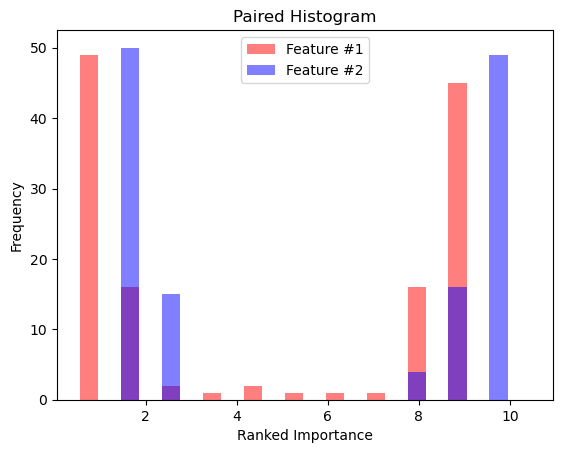

In [12]:
print("Local MDI+ w/ Leave-One-Out Coefficients and Outer Absolute Value")
print("------------------------------------")
lfi_loo_outer = mdi_plus_scores["lfi"]
print(lfi_loo_outer)
print("------------------------------------")
print("Recall that the first two columns are the only ones with signal.")
print("Histogram of Rank of First Column (Red) and Second Column (Blue)")
lfi_rank = lfi_loo_outer.rank(axis=1, method="dense", ascending=False)
fig, ax = plt.subplots()
ax.hist(lfi_rank.iloc[:, 0], alpha = 0.5, label='Feature #1', align = "left",
        width = 0.4, color = "red")
ax.hist(lfi_rank.iloc[:, 1], alpha = 0.5, label='Feature #2', align = "right",
        width = 0.4, color = "blue")
ax.set_xlabel('Ranked Importance')
ax.set_ylabel('Frequency')
ax.set_title('Paired Histogram')
ax.legend()
plt.show()